In [5]:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import highway_env   # registers roundabout-v0
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

In [6]:
# Kinematics obs config + feature→index map
kin_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x":  [-100, 100],
            "y":  [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order":    "sorted"
    }
}
feat2idx = {name: i for i, name in enumerate(kin_config["observation"]["features"])}
vx_idx   = feat2idx["vx"]
vy_idx   = feat2idx["vy"] 

# Hyper-parameters
env_id        = "roundabout-v0"
batch_size    = 64
max_steps     = 300 # 200
hidden_size   = 256
gamma         = 0.99
alpha         = 0.05
cost_limit    = 0.05
lr_policy     = 3e-4
lr_value      = 3e-4
lr_dual       = 1e-2
critic_coef = 0.0
entropy_coef  = 0.01
num_epochs    = 400
noise_scale   = 0.01
forward_coef  = 0.1      # bonus on forward speed
crash_penalty = 2.5      # immediate crash penalty
lateral_penalty_coef = 0.1  # new: penalize lateral speed
idle_thresh       = 0.1      # below this vx we start penalizing
idle_penalty_coef = 0.2      # extra penalty for being “too slow”
accel_penalty_coef = 0.005

failure_cap   = 50_000   # failure-only buffer size
failure_mix   = 0.2      # unused here but could mix failure/off
num_adv_steps = 3 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Failure-only buffer (must preceed its use)
class FailureBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *t):
        self.buf.append(t)
    def sample(self, n):
        idx = np.random.choice(len(self.buf), n, replace=False)
        return [self.buf[i] for i in idx]
    def __len__(self):
        return len(self.buf)

failure_buffer = FailureBuffer(failure_cap)

# Policy and Value nets
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=hidden_size):
        super().__init__()
        self.fc1    = nn.Linear(obs_dim, hidden)
        self.fc2    = nn.Linear(hidden, hidden)
        self.fc3    = nn.Linear(hidden, hidden)
        self.logits = nn.Linear(hidden, action_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.logits(h)
    def get_dist(self, x):
        return torch.distributions.Categorical(logits=self.forward(x))

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.v   = nn.Linear(hidden, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.v(h).squeeze(-1)

# Create vectorized envs with our kinematics config
def make_env():
    env = gym.make(env_id, config=kin_config)
    env.reset()
    return env

envs = AsyncVectorEnv([make_env for _ in range(batch_size)])
vc, nf = envs.single_observation_space.shape
obs_dim    = vc * nf
action_dim = envs.single_action_space.n

class AdvNet(nn.Module):
    def __init__(self, obs_dim, hidden=128, eps=0.05):
        super().__init__()
        self.eps = eps
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, obs_dim)
    def forward(self, x):
        # x: (B,obs_dim)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        delta = torch.tanh(self.fc3(h))  # in (−1,1)
        return delta * self.eps

adv_net  = AdvNet(obs_dim).to(device)
opt_adv  = torch.optim.Adam(adv_net.parameters(), lr=1e-3)

# Instantiate nets & optimizers
policy      = PolicyNet(obs_dim, action_dim).to(device)
value_net   = ValueNet(obs_dim).to(device)
opt_pol     = torch.optim.Adam(policy.parameters(), lr=lr_policy)
opt_val     = torch.optim.Adam(value_net.parameters(),   lr=lr_value)
lambda_cvar = torch.tensor(1.0, requires_grad=True, device=device)
mu_cost     = torch.tensor(1.0, requires_grad=True, device=device)
opt_dual    = torch.optim.Adam([lambda_cvar, mu_cost],   lr=lr_dual)

In [8]:
# 7) CVaR helper
def static_cvar(returns, α):
    sorted_r, _ = returns.sort()
    k           = max(1, int(α * sorted_r.numel()))
    return sorted_r[:k].mean()

# 8) Rollout + FGSM + forward bonus + lateral & crash penalties + record transitions
def collect_batch(envs, policy, max_steps):
    out = envs.reset()
    obs = out[0] if isinstance(out, tuple) else out
    obs = torch.tensor(obs, dtype=torch.float32, device=device)

    logps_buf, rews_buf = [], []
    crashed   = torch.zeros(batch_size, dtype=torch.bool, device=device)
    done_mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
    transitions = []

    # --- NEW: track previous speed for each env in the batch
    prev_speed = torch.zeros(batch_size, device=device)

    for _ in range(max_steps):
        # (FGSM adversary etc., unchanged)
        obs_adv  = obs.detach().clone().requires_grad_(True)
        flat_adv = obs_adv.view(batch_size, -1)
        dist_adv = policy.get_dist(flat_adv)
        a_adv    = dist_adv.sample()
        loss_adv = -dist_adv.log_prob(a_adv).mean()
        grads    = torch.autograd.grad(loss_adv, obs_adv)[0]
        obs      = (obs_adv + noise_scale * grads.sign()).detach()

        # policy step
        flat  = obs.view(batch_size, -1)
        dist  = policy.get_dist(flat)
        acts  = dist.sample()
        logps = dist.log_prob(acts)

        # step env
        step_out = envs.step(acts.cpu().numpy())
        if len(step_out) == 5:
            nxt, rews_raw, term, truncs, infos = step_out
            dones = np.logical_or(term, truncs)
        else:
            nxt, rews_raw, dones, infos = step_out
        dones = np.array(dones)
        done_mask |= torch.tensor(dones, device=device)

        # crash detection
        if isinstance(infos, dict):
            crash_np = np.array(infos.get("crashed", np.zeros(batch_size)), bool)
        elif isinstance(infos, list):
            crash_np = np.array([i.get("crashed",False) for i in infos], bool)
        else:
            crash_np = np.array(infos, bool)
        crashed |= torch.tensor(crash_np, device=device)

        # extract ego velocities BEFORE overwriting obs
        ego_vx = obs[:,0,vx_idx]
        ego_vy = obs[:,0,vy_idx]
        ego_speed = (ego_vx.pow(2) + ego_vy.pow(2)).sqrt()

        # --- NOW compute acceleration penalty ---
        accel     = ego_speed - prev_speed           # Δ speed
        accel_pen = accel.pow(2) * accel_penalty_coef
        prev_speed = ego_speed                       # update for next step

        idle_gap = (idle_thresh - ego_speed).clamp(min=0)      # how far below threshold
        idle_pen = idle_gap.pow(2) * idle_penalty_coef 

        # shape the reward
        base_r         = torch.tensor(rews_raw, device=device)
        crash_pen_term = crash_penalty * crash_np.astype(float)
        speed_bonus    = forward_coef * ego_speed
        r_t = base_r \
              - crash_pen_term \
              + speed_bonus \
              - accel_pen \
              - idle_pen
              

        logps_buf.append(logps)
        rews_buf.append(r_t)

        # record transition
        nxt_t    = torch.tensor(nxt, dtype=torch.float32, device=device)
        flat_nxt = nxt_t.view(batch_size, -1)
        for i in range(batch_size):
            transitions.append((
                flat[i].detach().cpu(),
                acts[i].item(),
                logps[i].detach().cpu(),
                float(r_t[i].item()),
                float(crash_np[i]),
                flat_nxt[i].cpu(),
                bool(dones[i])
            ))

        # next obs + a bit of noise
        obs = nxt_t + torch.randn_like(nxt_t)*(noise_scale*0.1)
        if done_mask.all():
            break

    # rest of function is unchanged...
    ep_C        = crashed.float()
    crash_count = int(crashed.sum().item())
    T = len(rews_buf)
    returns = torch.zeros(T, batch_size, device=device)
    G = torch.zeros(batch_size, device=device)
    for t in reversed(range(T)):
        G = rews_buf[t] + gamma * G
        returns[t] = G

    ep_R      = returns[0]
    all_logps = torch.cat(logps_buf)
    all_rets  = returns.flatten()
    return ep_R, ep_C, all_logps, all_rets, crash_count, transitions


# 9) One train-epoch: Lagrangian + alternating failure-buffer (optional)
def train_epoch(envs, policy, epoch):
    # 1) Adversary update 
    reset_out = envs.reset()
    obs0 = reset_out[0] if isinstance(reset_out, tuple) else reset_out
    obs0 = torch.tensor(obs0, device=device).view(batch_size, -1)
    for _ in range(num_adv_steps):
        δ        = adv_net(obs0)
        dist_adv = policy.get_dist(obs0 + δ)
        acts_adv = dist_adv.sample()
        loss_adv = -dist_adv.log_prob(acts_adv).mean()
        opt_adv.zero_grad(); loss_adv.backward(); opt_adv.step()

    # 2) Environment rollout 
    ep_R, ep_C, logps_o, rets_o, crash_count, trans = collect_batch(envs, policy, max_steps)

    # 3)  TD(0) critic—computed 
    # unpack transitions
    states      = torch.stack([t[0] for t in trans]).to(device)   # (T*B, obs_dim)
    rewards     = torch.tensor([t[3] for t in trans], device=device)
    next_states = torch.stack([t[5] for t in trans]).to(device)
    dones       = torch.tensor([t[6] for t in trans], device=device, dtype=torch.float32)

    # one-step bootstrap target
    with torch.no_grad():
        V_next = value_net(next_states)                         # no grad
        target = rewards + gamma * V_next * (1.0 - dones)

    V_pred     = value_net(states)                              # requires grad
    raw_value_loss = F.mse_loss(V_pred, target)

    # scale by zero so no real update happens
    value_loss = critic_coef * raw_value_loss
    opt_val.zero_grad()
    value_loss.backward()
    opt_val.step()

    # 4) Build on-policy surrogate & cost 
    baseline = rets_o.mean().detach()
    adv_on   = rets_o - baseline
    loss_on  = - (logps_o * adv_on).mean()
    cost_on  = ep_C.mean()

    # 5) Failure‐only replay 
    use_fail = (epoch % 2 == 0) and (len(failure_buffer) >= batch_size)
    if use_fail:
        batch = failure_buffer.sample(batch_size)
        s_f, a_f, lp_old, r_f, c_f, nxt_f, d_f = zip(*batch)
        s_f    = torch.stack(s_f).to(device)
        a_f    = torch.tensor(a_f, device=device)
        lp_old = torch.stack(lp_old).to(device)
        r_f    = torch.tensor(r_f, device=device)

        dist_f   = policy.get_dist(s_f)
        lp_new   = dist_f.log_prob(a_f)
        with torch.no_grad():
            w = (lp_new - lp_old).exp().clamp(max=10.0)

        adv_f     = r_f - r_f.mean().detach()
        loss_surr = - (w * lp_new * adv_f).mean()
        avg_cost  = cost_on
    else:
        loss_surr = loss_on
        avg_cost  = cost_on

    # CVaR & crash penalty 
    cvar       = static_cvar(ep_R, alpha)
    slack      = avg_cost - cost_limit
    cost_pen   = mu_cost * torch.clamp(slack, min=0.0)**2

    # Policy update 
    L = loss_surr - lambda_cvar * cvar + cost_pen
    opt_pol.zero_grad()
    L.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
    opt_pol.step()

    # Dual ascent on μ 
    opt_dual.zero_grad()
    dual_loss = - mu_cost * torch.clamp(slack, min=0.0)**2
    dual_loss.backward()
    opt_dual.step()
    mu_cost.data.clamp_(0.0, 50.0)

    # Stash failures 
    if crash_count > 0:
        for tr in trans:
            failure_buffer.push(*tr)

    return (
        float(ep_R.mean().item()),
        float(cvar.item()),
        float(avg_cost.item()),
        float(mu_cost.item()),
        int(crash_count)
    )

In [9]:
## 10) Main loop + logging + plotting

In [10]:
logs = []
t0 = time.time()
for ep in range(num_epochs):
    R, CVaR, C, mu, crashes = train_epoch(envs, policy, ep)
    logs.append((R, CVaR, C, mu, crashes))
    if ep % 10 == 0:
        print(f"Ep {ep:03d} | R={R:.2f} CVaR={CVaR:.2f} "
              f"C={C:.2f} μ={mu:.2f} crashes={crashes}")
print("Total time:", time.time() - t0)

Ep 000 | R=7.88 CVaR=0.92 C=0.31 μ=1.01 crashes=20
Ep 010 | R=8.42 CVaR=2.96 C=0.31 μ=1.11 crashes=20
Ep 020 | R=8.06 CVaR=2.19 C=0.31 μ=1.20 crashes=20
Ep 030 | R=8.25 CVaR=2.05 C=0.30 μ=1.28 crashes=19
Ep 040 | R=8.11 CVaR=3.05 C=0.33 μ=1.36 crashes=21
Ep 050 | R=8.53 CVaR=1.93 C=0.19 μ=1.44 crashes=12
Ep 060 | R=8.50 CVaR=5.10 C=0.22 μ=1.52 crashes=14
Ep 070 | R=8.54 CVaR=5.22 C=0.20 μ=1.58 crashes=13
Ep 080 | R=8.69 CVaR=3.90 C=0.17 μ=1.63 crashes=11
Ep 090 | R=8.80 CVaR=5.06 C=0.17 μ=1.65 crashes=11
Ep 100 | R=8.92 CVaR=5.46 C=0.14 μ=1.68 crashes=9
Ep 110 | R=8.90 CVaR=5.32 C=0.12 μ=1.70 crashes=8
Ep 120 | R=8.86 CVaR=4.01 C=0.08 μ=1.72 crashes=5
Ep 130 | R=9.42 CVaR=8.70 C=0.00 μ=1.72 crashes=0
Ep 140 | R=9.28 CVaR=5.87 C=0.08 μ=1.73 crashes=5
Ep 150 | R=9.04 CVaR=5.54 C=0.16 μ=1.74 crashes=10
Ep 160 | R=8.91 CVaR=5.70 C=0.22 μ=1.76 crashes=14
Ep 170 | R=9.23 CVaR=5.74 C=0.20 μ=1.78 crashes=13
Ep 180 | R=9.29 CVaR=5.60 C=0.22 μ=1.84 crashes=14
Ep 190 | R=9.48 CVaR=5.78 C=0.19 μ=1

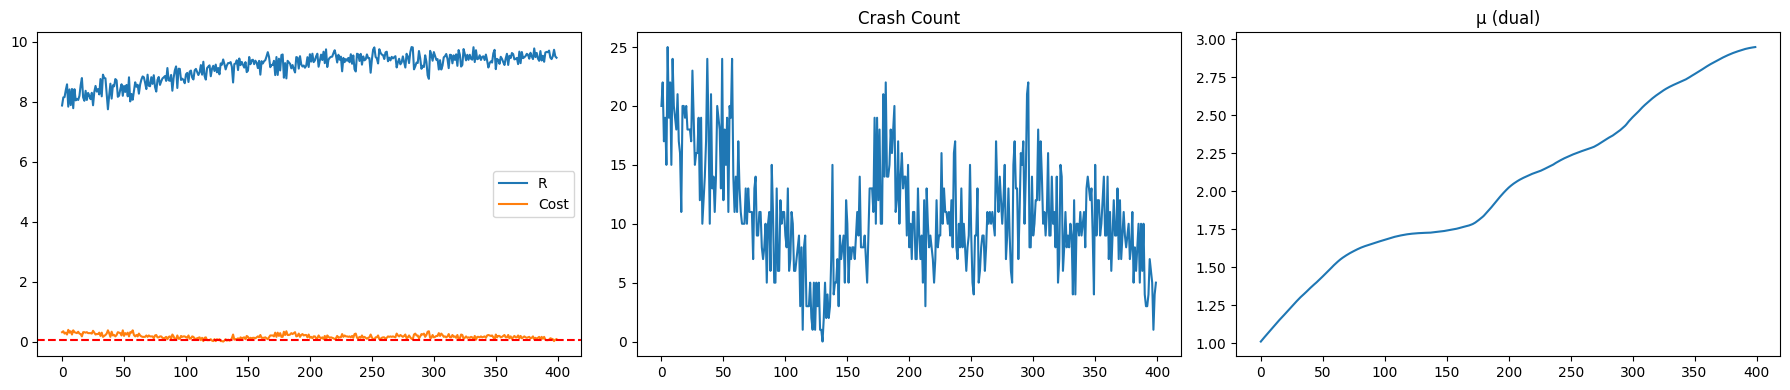

In [11]:
df = pd.DataFrame(logs, columns=["R","CVaR","Cost","μ","crashes"])
fig, ax = plt.subplots(1,3,figsize=(18,4))
df[["R","Cost"]].plot(ax=ax[0]); ax[0].axhline(cost_limit, ls='--', c='r')
df["crashes"].plot(ax=ax[1]).set_title("Crash Count")
df["μ"].plot(ax=ax[2]).set_title("μ (dual)")
plt.tight_layout()
plt.show()

In [12]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import glob, os
from IPython.display import HTML

# --- parameters ---
num_videos   = 5
video_folder = "Final_2"

# 1) make your env (with kinematics config) and wrap it
base_env = gym.make(
    "roundabout-v0",
    render_mode="rgb_array",
    config=kin_config
)
env = RecordVideo(
    base_env,
    video_folder=video_folder,
    episode_trigger=lambda ep: ep < num_videos,
    name_prefix="roundabout_run"
)

# 2) run exactly num_videos episodes
for ep in range(num_videos):
    obs, info = env.reset()
    done = False
    while not done:
        # flatten & to tensor
        flat = torch.tensor(obs, dtype=torch.float32, device=device).view(1, -1)
        # sample action
        action = policy.get_dist(flat).sample().item()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

# 3) close and finalize files
env.close()

# 4) find & embed the 5 videos
mp4_paths = sorted(glob.glob(os.path.join(video_folder, "roundabout_run*.mp4")))
# only keep the first num_videos
mp4_paths = mp4_paths[:num_videos]

# display them inline
for path in mp4_paths:
    display(HTML(f"""
    <h4>{os.path.basename(path)}</h4>
    <video width="480" controls>
      <source src="{path}" type="video/mp4">
    </video>
    """))


/home/personooo/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/personooo/Desktop/Code/ml final/real attempt/Final_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [7]:
torch.save(policy.state_dict(), "Final_2b.pt")

In [14]:
import gymnasium as gym
import highway_env   # registers roundabout-v0
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import pygame
import time

# 0) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) kinematics config + feature→index
kin_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence","x","y","vx","vy","cos_h","sin_h"],
        "features_range": {
            "x":  [-100, 100], "y":  [-100, 100],
            "vx": [ -20,  20], "vy": [ -20,  20]
        },
        "absolute": False,
        "order":    "sorted"
    }
}
feat2idx = {n:i for i,n in enumerate(kin_config["observation"]["features"])}
vx_idx, vy_idx = feat2idx["vx"], feat2idx["vy"]

# 2) rebuild PolicyNet & load weights
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=256):
        super().__init__()
        self.fc1    = nn.Linear(obs_dim, hidden)
        self.fc2    = nn.Linear(hidden, hidden)
        self.fc3    = nn.Linear(hidden, hidden)
        self.logits = nn.Linear(hidden, action_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.logits(h)
    def get_dist(self, x):
        return torch.distributions.Categorical(logits=self.forward(x))

# dummy env to get dims
tmp = gym.make("roundabout-v0", config=kin_config)
o0,_ = tmp.reset()
vc,nf = tmp.observation_space.shape
obs_dim = vc*nf
act_dim = tmp.action_space.n
tmp.close()

policy = PolicyNet(obs_dim, act_dim).to(device).eval()
policy.load_state_dict(torch.load("Final_2.pt", map_location=device))

# 3) metric helpers
def min_distance(kin_obs):
    pres = kin_obs[:,0]>0
    if not pres.any(): return 0.0
    pos = kin_obs[pres,1:3]
    return float(np.linalg.norm(pos,axis=1).min())

def time_to_collision(kin_obs):
    pres = kin_obs[:,0]>0
    if not pres.any(): return float('inf')
    pos = kin_obs[pres,1:3]
    vel = kin_obs[pres,3:5]
    dists = np.linalg.norm(pos,axis=1)
    rel   = np.sum(pos*vel,axis=1)/(dists+1e-6)
    mask  = rel<0
    if not mask.any(): return float('inf')
    ttc   = dists[mask]/(-rel[mask]+1e-6)
    return float(ttc.min())

# 4) init pygame & clock
pygame.init()
clock = pygame.time.Clock()

# 5) make env in rgb_array mode
env = gym.make("roundabout-v0", render_mode="rgb_array", config=kin_config)

# 6) reset once and grab a frame to size the video
obs, _ = env.reset()
frame   = env.render()
H, W    = frame.shape[:2]
FPS     = 15
out = cv2.VideoWriter(
    "Final_play.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    FPS, (W, H)
)

# 7) roll episodes
num_episodes = 5
for ep in range(num_episodes):
    obs, _ = env.reset()
    cum_r   = 0.0
    crashes = 0
    done    = False

    while not done:
        # --- act ---
        x  = torch.tensor(obs, dtype=torch.float32, device=device).view(1,-1)
        a  = policy.get_dist(x).sample().item()
        obs2, r, term, trunc, info = env.step(a)
        done = term or trunc

        # stats
        cum_r += r
        if info.get("crashed", False):
            crashes += 1

        # compute metrics from raw obs
        kin = obs.copy()  # (15,7)
        md  = min_distance(kin)
        ttc = time_to_collision(kin)
        spd = float(np.linalg.norm(kin[0,3:5]))

        # grab frame
        frame = env.render()
        if frame is None:
            surf  = pygame.display.get_surface()
            arr   = pygame.surfarray.array3d(surf)
            frame = np.transpose(arr, (1,0,2))
        img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # overlay text
        cv2.putText(img, f"Ep {ep+1}/{num_episodes}", (10,25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        cv2.putText(img, f"Cum R: {cum_r:6.2f}", (10,55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
        cv2.putText(img, f"Crashes: {crashes}", (10,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 1)
        cv2.putText(img, f"Speed: {spd:4.2f} m/s", (10,115),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1)
        cv2.putText(img, f"Min-dist: {md:5.2f} m", (10,145),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1)
        cv2.putText(img, f"TTC: {ttc:5.2f} s", (10,175),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1)

        # write and cap to 15 FPS
        out.write(img)
        clock.tick(FPS)

        obs = obs2

out.release()
env.close()
pygame.quit()
print("Wrote overlay_demo3.mp4")


/tmp/ipykernel_1720964/3567650675.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("Final_2.pt", map_location=device))


Wrote overlay_demo3.mp4
